In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller


## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [8]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory


event_frac = 0.01 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

<Figure size 1440x720 with 0 Axes>

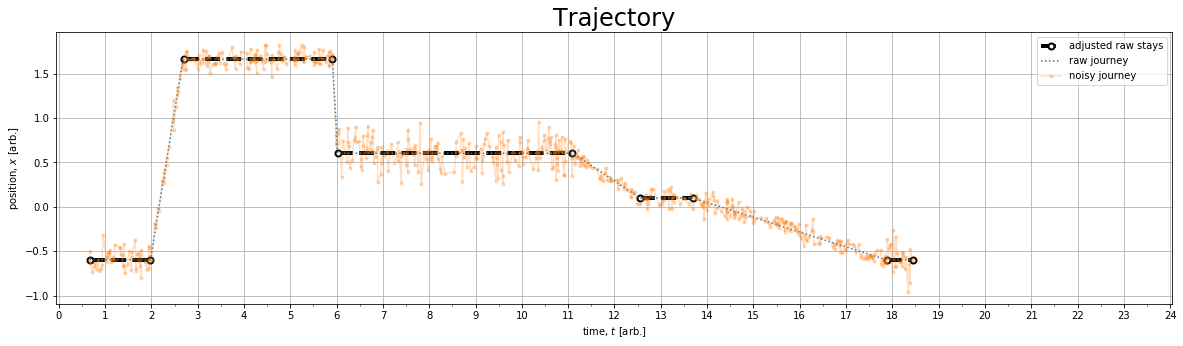

In [9]:
time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

# Clustering

## Split the clusters which have a temporal gap

In [10]:
time_thresh = 1/6
eps=0.25

In [11]:
clusters = list(range(time_arr.size))

In [12]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

### Basic cluster identification

In [30]:
clusters = get_clusters(time_arr, noise_arr, eps, time_thresh)
len(clusters)

14

In [31]:
print("just the end-point indices:")
for clust in clusters:
    print(f"[{clust[0]},{clust[-1]}]")

just the end-point indices:
[0,8]
[11,54]
[81,199]
[224,237]
[241,250]
[270,291]
[297,315]
[329,349]
[352,362]
[389,421]
[423,528]
[530,596]
[598,627]
[632,640]


### Raw plotting

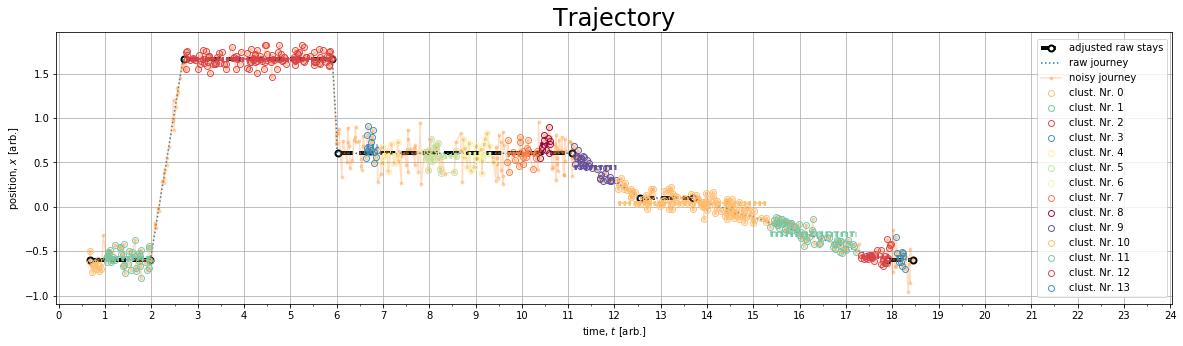

In [32]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]
    
    ax.plot(time_arr[clust], noise_arr[clust], 'o', color=color, alpha=0.95, markerfacecolor="None", label=f'clust. Nr. {cl_nr}')
    
    clust_med = np.median(noise_arr[clust])    
    ax.plot([time_arr[clust[0]],time_arr[clust[-1]]], [clust_med,clust_med], '--', color=color, alpha=0.95, label=None)
    
    clust_mean = np.mean(noise_arr[clust])    
    ax.plot([time_arr[clust[0]],time_arr[clust[-1]]], [clust_mean,clust_mean], '--', dashes=[0.5, 0.5], lw=5, color=color, alpha=0.95, label=None)
    
ax.legend(loc=7);

### IQR-plotting

In [33]:
box_plots = []
positions = []
widths = []
for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]  
    
    # Get the subseqs
    xs = time_arr[clust]
    ys = noise_arr[clust]
    box_plots.append(ys)
    widths.append(xs[-1]-xs[0])
    positions.append((xs[-1]+xs[0])/2)

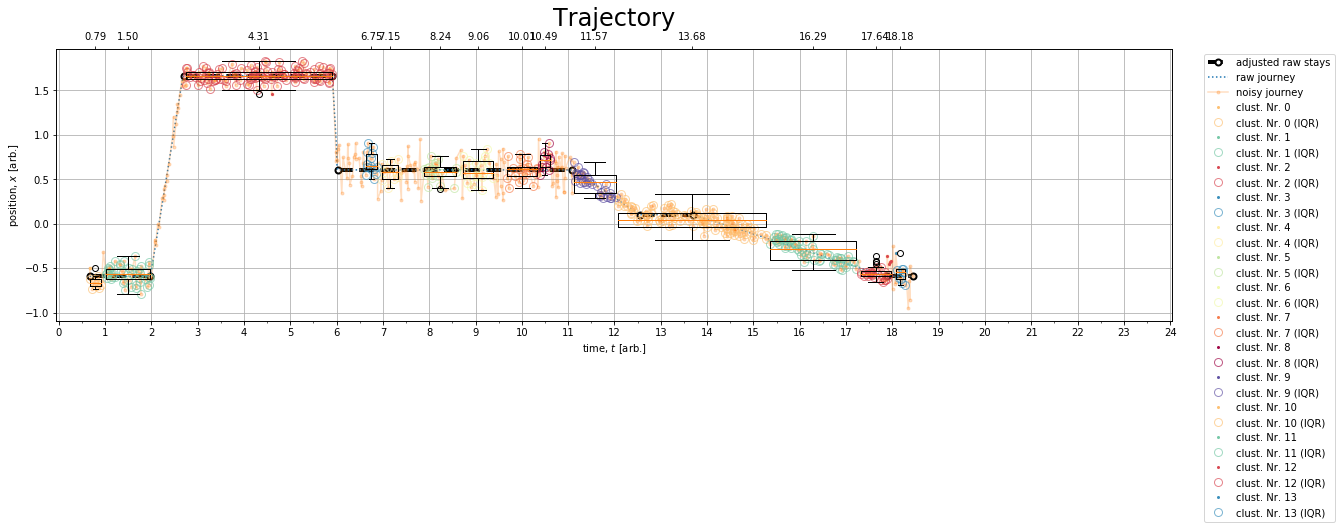

In [34]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]  
    
    # Get the subseqs
    xs = time_arr[clust]
    ys = noise_arr[clust]

    # Mask to include only events within the IQR
    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')
    iqr = abs(q75 - q25)
    iqr_fact = 1.5
    
    # Apply the "without" mask
    mask=np.where((ys <= (q25 - iqr_fact * iqr)) | (ys >= (q75 + iqr_fact * iqr)))
    ax.plot(xs[mask], ys[mask], '.', alpha=0.95, color=color, markersize=4.0, label=f'clust. Nr. {cl_nr}')
    
    # Apply the "within" mask    
    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))        
    ax.plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.65, markerfacecolor="None", label=f'clust. Nr. {cl_nr} (IQR)')

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(box_plots, labels=labels, positions=positions, widths=widths)      
axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [35]:
get_err = lambda x1, x2: np.sqrt((x1-x2)**2)

def get_clusters_rev(t_arr, loc_arr, dist_thresh, time_thresh, verbose=False):

    """
    Get a list of cluster indices

    :param t_arr: np.array Trajectory array of timepoints
    :param timepoint: float Timepoint
    :param time_thresh: float buff around timepoint  
    :param direction: int gets the min or max index of a region
    
    :return: int endpoint index of a region
    
    """
    
    # Output list of indices: [[beg., end],[beg., end], ...] 
    clusters = []

    m = 0

    # The current cluster indices: [n_0, n_1, ... ]
    new_cluster = []
    
    # Pass through the list of events
    for n in range(0,loc_arr.size-3):

        # Check: is the time within the time thresh?
        if abs(t_arr[n+1] - t_arr[n]) <= time_thresh:
            event_loc = loc_arr[n+1]
        else: 
            continue

        # Get the current cluster mean
        cluster_mean = np.mean(loc_arr[m:n+1])

        # Get the potential cluster mean    
        new_cluster_mean = np.mean(loc_arr[m:n+2])

        err1 = get_err(cluster_mean, event_loc)
        err2 = get_err(cluster_mean, new_cluster_mean)
        if verbose: print(n, err1, err2, dist_thresh)
 
        # Checks: 
        # 1. new event is within dist. thresh of current clust.
        # 2. new mean - current mean is within dist. thresh.
        if  (err1 < dist_thresh) & (err2 < dist_thresh) & \
            (n <= loc_arr.size-5):
            new_cluster.append(n)
        else:
            # Save the current cluster and prepare restart
            txt = f'Trying {n} '
            app = "Nope"
            if (len(new_cluster) >= 2):
                if (abs(t_arr[new_cluster[-1]]-t_arr[new_cluster[0]]) > time_thresh):
                    clusters.append(new_cluster)
                    app = 'closed'
 
            new_cluster = []

            # Update starting point
            m=n+1
            
    return clusters


In [86]:
clusters_rev = get_clusters_rev(time_arr[::-1], noise_arr[::-1], eps, time_thresh)
len(clusters_rev)

14

In [88]:
time_thresh

0.16666666666666666

In [94]:
rev_time_arr = time_arr[::-1].copy()
for clust in clusters_rev:
    print(clust[0],clust[-1],time_arr[::-1][clust].max()-time_arr[::-1][clust].min())
    print(clust[0],clust[-1],rev_time_arr[clust].max()-rev_time_arr[clust].min())              

5 15 0.22361111111111143
5 15 0.22361111111111143
19 75 1.6463888888888896
19 75 1.6463888888888896
77 132 1.554722222222221
77 132 1.554722222222221
134 219 2.4719444444444445
134 219 2.4719444444444445
221 255 0.9875000000000007
221 255 0.9875000000000007
287 294 0.19833333333333414
287 294 0.19833333333333414
296 317 0.6650000000000009
296 317 0.6650000000000009
337 348 0.3741666666666674
337 348 0.3741666666666674
362 375 0.2577777777777772
362 375 0.2577777777777772
379 385 0.17138888888888903
379 385 0.17138888888888903
395 405 0.3761111111111113
395 405 0.3761111111111113
413 423 0.21083333333333343
413 423 0.21083333333333343
446 569 3.250555555555555
446 569 3.250555555555555
591 634 0.967222222222222
591 634 0.967222222222222


In [95]:
print("just the end-point indices:")
for clust in clusters:
    print(f"[{clust[0]},{clust[-1]}]")
for clust in clusters_rev:
    print(f"[{clust[0]},{clust[-1]}]")

just the end-point indices:
[0,8]
[11,54]
[81,199]
[224,237]
[241,250]
[270,291]
[297,315]
[329,349]
[352,362]
[389,421]
[423,528]
[530,596]
[598,627]
[632,640]
[5,15]
[19,75]
[77,132]
[134,219]
[221,255]
[287,294]
[296,317]
[337,348]
[362,375]
[379,385]
[395,405]
[413,423]
[446,569]
[591,634]


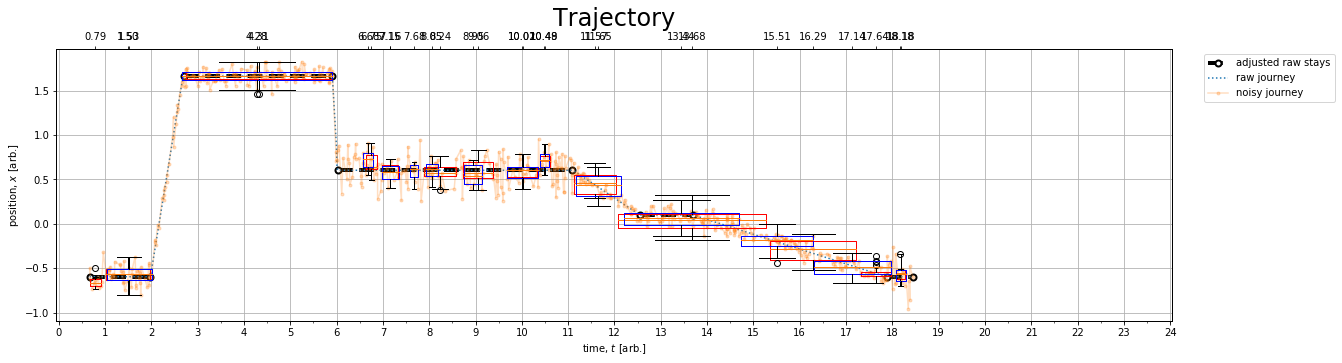

In [96]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

box_plots = []
positions = []
widths = []
for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]  
    
    # Get the subseqs
    xs = time_arr[clust]
    ys = noise_arr[clust]
    box_plots.append(ys)
    widths.append(xs[-1]-xs[0])
    positions.append((xs[-1]+xs[0])/2)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(box_plots, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

axt.set_xlim(ax.get_xlim())


box_plots = []
positions = []
widths = []
for cl_nr, clust in enumerate(clusters_rev):
    
    color=colors[cl_nr%len(colors)]  
    
    # Get the subseqs
    xs = time_arr[::-1][clust]
    ys = noise_arr[::-1][clust]
    box_plots.append(ys)
    widths.append(abs(xs[-1]-xs[0]))
    positions.append((xs[-1]+xs[0])/2)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(box_plots, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)   


axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [ ]:
    # Get the subseqs
    xs = time_arr[clust]
    ys = noise_arr[clust]

    # Mask to include only events within the IQR
    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')
    iqr = abs(q75 - q25)
    iqr_fact = 1.5
    

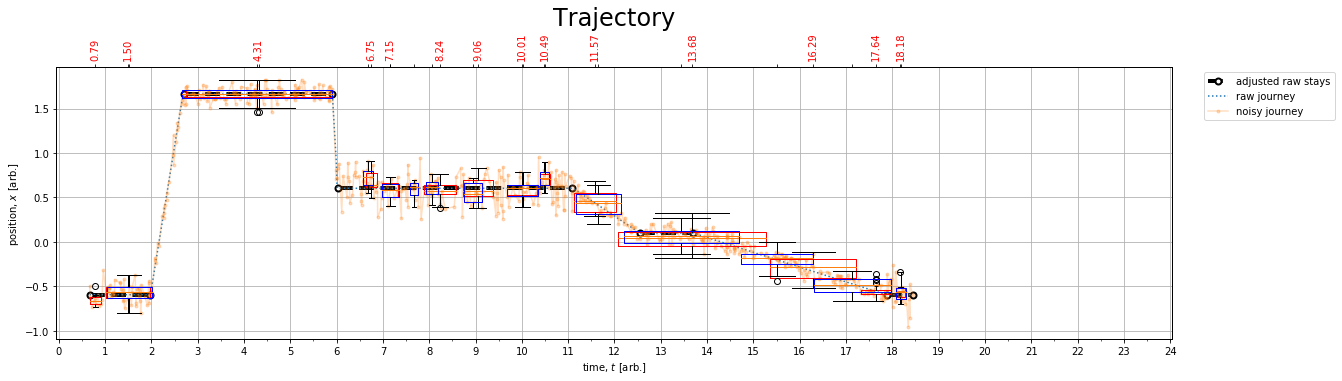

In [106]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

box_plots = []
positions = []
widths = []
for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]  
    
    # Get the subseqs
    xs = time_arr[clust]
    ys = noise_arr[clust]

    # Mask to include only events within the IQR
    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')
    iqr = abs(q75 - q25)
    iqr_fact = 1.5
    
    full_iqr, min_iqr = iqr_metrics(ys,1.5)
    
    if min_iqr < 20*eps:

        box_plots.append(ys)
        widths.append(xs[-1]-xs[0])
        positions.append((xs[-1]+xs[0])/2)

#print(widths)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(box_plots, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())


box_plots = []
positions = []
widths = []
for cl_nr, clust in enumerate(clusters_rev):
    
    color=colors[cl_nr%len(colors)]  
    
    # Get the subseqs
    xs = time_arr[::-1][clust]
    ys = noise_arr[::-1][clust]

    # Mask to include only events within the IQR
    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')
    iqr = abs(q75 - q25)
    iqr_fact = 1.5
    
    full_iqr, min_iqr = iqr_metrics(ys,1.5)
    
    if min_iqr < 20*eps:

        box_plots.append(ys)
        widths.append(xs[-1]-xs[0])
        pos = (xs[-1]+xs[0])/2
        positions.append(pos)
        #print(pos,iqr,clust)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(box_plots, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

[0.25055555555555553, 0.946388888888889, 3.154166666666667, 0.23694444444444418, 0.3544444444444448, 0.6791666666666663, 0.6408333333333331, 0.6430555555555557, 0.21333333333333293, 0.9033333333333342, 3.1958333333333346, 1.8591666666666686, 0.6466666666666647, 0.20500000000000185]
[-0.22361111111111143, -1.6463888888888896, -1.554722222222221, -2.4719444444444445, -0.9875000000000007, -0.19833333333333414, -0.6650000000000009, -0.3741666666666674, -0.2577777777777772, -0.17138888888888903, -0.3761111111111113, -0.21083333333333343, -3.250555555555555, -0.967222222222222]


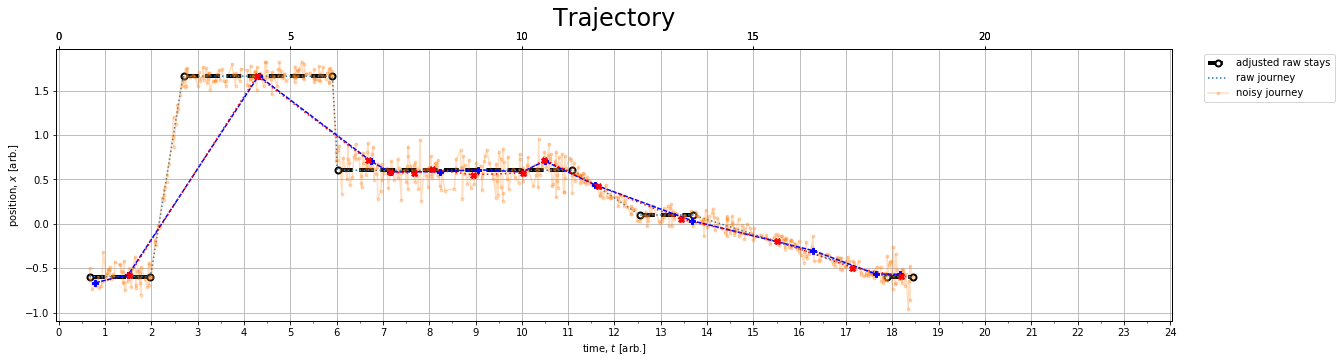

In [101]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

box_plots = []
positions = []
widths = []
for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]  
    
    # Get the subseqs
    xs = time_arr[clust]
    ys = noise_arr[clust]

    # Mask to include only events within the IQR
    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')
    iqr = abs(q75 - q25)
    iqr_fact = 1.5
    
    full_iqr, min_iqr = iqr_metrics(ys,1.5)
    
    if min_iqr < 20*eps:

        box_plots.append((q25+q75)*0.5)
        widths.append(xs[-1]-xs[0])
        positions.append((xs[-1]+xs[0])/2)

print(widths)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.plot(positions,box_plots,'bP--', dashes=[3,1])
axt.set_xlim(ax.get_xlim())


box_plots = []
positions = []
widths = []
for cl_nr, clust in enumerate(clusters_rev):
    
    color=colors[cl_nr%len(colors)]  
    
    # Get the subseqs
    xs = time_arr[::-1][clust]
    ys = noise_arr[::-1][clust]

    # Mask to include only events within the IQR
    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')
    iqr = abs(q75 - q25)
    iqr_fact = 1.5
    
    full_iqr, min_iqr = iqr_metrics(ys,1.5)
    
    if min_iqr < 20*eps:

        box_plots.append((q25+q75)*0.5)
        widths.append(xs[-1]-xs[0])
        pos = (xs[-1]+xs[0])/2
        positions.append(pos)
        #print(pos,iqr,clust)

print(widths)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.plot(positions,box_plots,'rX--', dashes=[1,2])   


axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [49]:
np.percentile(noise_arr[413:570],q=np.arange(0,100,10))

array([-0.43416895, -0.2280661 , -0.17492103, -0.12274362, -0.060668  ,
       -0.0023641 ,  0.04081215,  0.08760659,  0.13884873,  0.20567806])

0.35891579028947695 -0.5385338420386211 0.4185749320666508


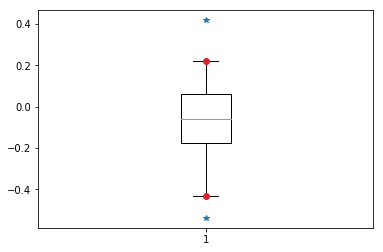

In [69]:
clust = [446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569]
ys = noise_arr[clust]

# Mask to include only events within the IQR
q25 = np.quantile(ys,0.25, interpolation='lower')
q75 = np.quantile(ys,0.75, interpolation='higher')
iqr = abs(q75 - q25)
iqr_fact = 1.5
iqr_boost = iqr*iqr_fact
print(iqr*iqr_fact,q25-iqr_boost,q75+iqr_boost)
_ = plt.boxplot(ys)

plt.plot(1, q25-iqr_boost, 'C0*')
plt.plot(1, ys[np.where(ys > q25-iqr_boost )].min(), 'C3o')
plt.plot(1, q75+iqr_boost, 'C0*')
plt.plot(1, ys[np.where(ys < q75+iqr_boost )].max(), 'C3o')

In [61]:
print(q75+iqr_boost, ys[np.where(ys < q75+iqr_boost )].max())

0.4185749320666508 0.22119226998636585


In [63]:
print(q25-iqr_boost, ys[np.where(ys > q25-iqr_boost )].min())

-0.5385338420386211 -0.4341689470406968


In [70]:
0.4185749320666508+0.5385338420386211

0.957108774105272

In [73]:
q75 - q25 + 2*iqr_boost

0.9571087741052718

In [74]:
ys[np.where(ys < q75+iqr_boost )].max() - ys[np.where(ys > q25-iqr_boost )].min()

0.6553612170270626

In [75]:
def iqr_metrics(data, iqr_fact=1.5):
    # Mask to include only events within the IQR
    q25 = np.quantile(data, 0.25, interpolation='lower')
    q75 = np.quantile(data, 0.75, interpolation='higher')
    iqr = abs(q75 - q25)

    iqr_boost = iqr*iqr_fact
    
    full_range = q75 - q25 + 2*iqr_boost
    min_range = ys[np.where(ys < q75+iqr_boost )].max() - ys[np.where(ys > q25-iqr_boost )].min()
    
    return full_range, min_range

In [76]:
iqr_metrics(ys,1.5)

(0.9571087741052718, 0.6553612170270626)